In [19]:
import findspark
findspark.init()

import pyspark
import random

import math
import pandas_datareader as web
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM,Dropout
import matplotlib.pyplot as plt

fileName = "/Users/lingzhuo/Desktop/256/Stock/IBMStockData.csv"

#initial a spark cluster
spark = pyspark.sql.SparkSession.builder.appName("StockPrice").config("spark.some.config.option", "some-value").getOrCreate()
#spark = pyspark.sql.SparkSession.builder.master("local").appName("StockMarket").config("spark.executor.memory", "6gb").getOrCreate()
#Use spark.read() to access this. Loads a CSV file and returns the result as a DataFrame.
df = spark.read.csv(fileName, header=True, inferSchema=True)

In [20]:
spark.conf.set("spark.sql.execution.arrow.enabled", "true")
data = df.select('Open','High','Low','Volume','Polarity','Close').toPandas()
print(data)
data['Close'] = data['Close'].shift(-5,fill_value= 0)
data.drop(data.tail(5).index,inplace=True)
print(data)
dataset = data.to_numpy()

          Open    High     Low  Volume  Polarity   Close
0       112.28  112.28  112.28     120  0.000000  112.28
1       112.53  112.70  112.28  134096  0.103571  112.30
2       112.28  112.36  112.15   20521  0.103571  112.17
3       112.17  112.36  112.17   20044  0.103571  112.33
4       112.32  112.36  112.12   21591  0.103571  112.25
...        ...     ...     ...     ...       ...     ...
427619  125.92  126.26  125.91   48228  0.000000  126.22
427620  126.22  126.41  126.22   44881  0.000000  126.41
427621  126.42  126.50  126.35   44224  0.000000  126.48
427622  126.49  126.60  126.44   59030  0.000000  126.59
427623  126.59  126.59  126.25  148971  0.000000  126.25

[427624 rows x 6 columns]
           Open     High     Low  Volume  Polarity   Close
0       112.280  112.280  112.28     120  0.000000  112.20
1       112.530  112.700  112.28  134096  0.103571  112.27
2       112.280  112.360  112.15   20521  0.103571  112.36
3       112.170  112.360  112.17   20044  0.103571  1

In [21]:
#Get /Compute the number of rows to train the model on
training_data_len = math.ceil( len(dataset) *.8) 

#Create the scaled training data set and test data set
train_data = dataset[0:training_data_len]
test_data = dataset[training_data_len :]

print(train_data[0], len(train_data))
print('-------------')
print(test_data[0], len(test_data))


#Scale the all of the data to be values between 0 and 1 
scaler = MinMaxScaler(feature_range=(0, 1)) 
scaled_train_data = scaler.fit_transform(train_data)
scaled_test_data = scaler.fit_transform(test_data)

print(scaled_train_data[0])
print('-------------')
print(scaled_test_data[0])

[112.28 112.28 112.28 120.     0.   112.2 ] 342096
-------------
[1.31780000e+02 1.31830000e+02 1.31780000e+02 2.48600000e+03
 2.67929293e-01 1.31930000e+02] 85523
[2.29371079e-01 2.28814922e-01 2.30633237e-01 5.44928034e-06
 5.00000000e-01 2.28033473e-01]
-------------
[0.61869414 0.61644667 0.62568306 0.00098574 0.60956229 0.62094877]


In [22]:
xtrain = scaled_train_data[:, 0:-1]
ytrain = scaled_train_data[:, -1:]

xtest = scaled_test_data[:, 0:-1]
ytest = scaled_test_data[:, -1:]

print('xtrain shape = {}'.format(xtrain.shape))
print('xtest shape = {}'.format(xtest.shape))
print('ytrain shape = {}'.format(ytrain.shape))
print('ytest shape = {}'.format(ytest.shape))

xtrain shape = (342096, 5)
xtest shape = (85523, 5)
ytrain shape = (342096, 1)
ytest shape = (85523, 1)


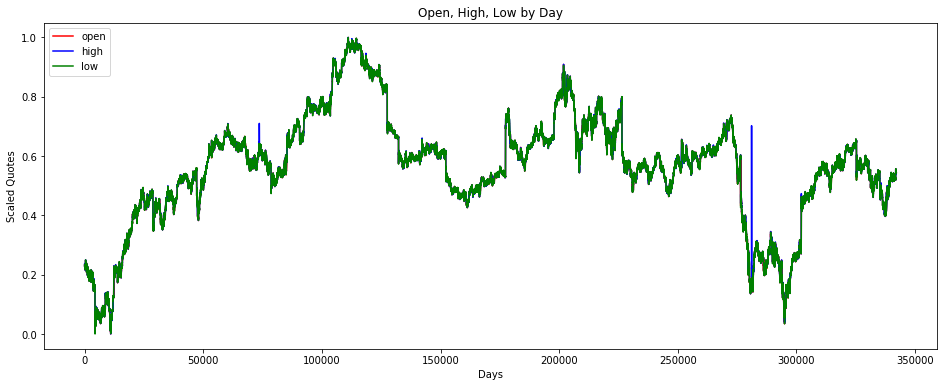

In [23]:
plt.figure(figsize=(16,6))
plt.plot(xtrain[:,0],color='red', label='open')
plt.plot(xtrain[:,1],color='blue', label='high')
plt.plot(xtrain[:,2],color='green', label='low')
plt.legend(loc = 'upper left')
plt.title('Open, High, Low by Day')
plt.xlabel('Days')
plt.ylabel('Scaled Quotes')
plt.show()

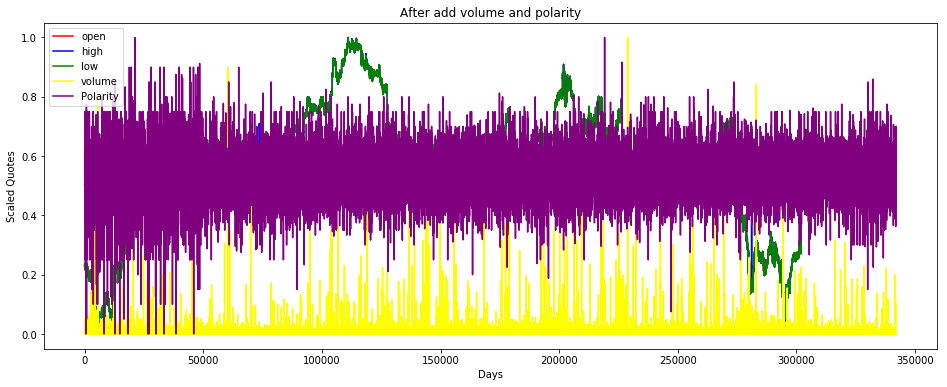

In [24]:
#volume and Polarity are very noisy
plt.figure(figsize=(16,6))
plt.plot(xtrain[:,0],color='red', label='open')
plt.plot(xtrain[:,1],color='blue', label='high')
plt.plot(xtrain[:,2],color='green', label='low')
plt.plot(xtrain[:,3],color='yellow', label='volume')
plt.plot(xtrain[:,4],color='purple', label='Polarity')
plt.legend(loc = 'upper left')
plt.title('After add volume and polarity')
plt.xlabel('Days')
plt.ylabel('Scaled Quotes')
plt.show()

In [25]:
from keras import models, layers
model = models.Sequential()
model.add(layers.LSTM(1, input_shape=(1,5)))
model.add(layers.Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
print(xtrain.shape)
xtrain = xtrain.reshape((xtrain.shape[0], 1, xtrain.shape[1]))
xtest  = xtest.reshape((xtest.shape[0], 1, xtest.shape[1]))
print('The shape of xtrain is {}: '.format(xtrain.shape))
print('The shape of xtest is {}: '.format(xtest.shape))

loss = model.fit(xtrain, ytrain, batch_size=128, epochs=100)

(342096, 5)
The shape of xtrain is (342096, 1, 5): 
The shape of xtest is (85523, 1, 5): 
Epoch 1/100
342096/342096 [==============================] - 5s 15us/step - loss: 0.0159
Epoch 2/100
342096/342096 [==============================] - 4s 13us/step - loss: 1.1855e-04
Epoch 3/100
342096/342096 [==============================] - 4s 12us/step - loss: 6.9179e-05
Epoch 4/100
342096/342096 [==============================] - 4s 12us/step - loss: 4.8715e-05
Epoch 5/100
342096/342096 [==============================] - 5s 13us/step - loss: 3.5208e-05
Epoch 6/100
342096/342096 [==============================] - 5s 15us/step - loss: 2.8323e-05
Epoch 7/100
342096/342096 [==============================] - 6s 18us/step - loss: 2.4358e-05
Epoch 8/100
342096/342096 [==============================] - 6s 17us/step - loss: 2.1914e-05
Epoch 9/100
342096/342096 [==============================] - 5s 14us/step - loss: 2.0173e-05
Epoch 10/100
342096/342096 [==============================] - 5s 14us/step - 

342096/342096 [==============================] - 5s 14us/step - loss: 1.1423e-05
Epoch 84/100
342096/342096 [==============================] - 4s 12us/step - loss: 1.1451e-05
Epoch 85/100
342096/342096 [==============================] - 5s 14us/step - loss: 1.1549e-05
Epoch 86/100
342096/342096 [==============================] - 4s 12us/step - loss: 1.1382e-05
Epoch 87/100
342096/342096 [==============================] - 4s 12us/step - loss: 1.1377e-05
Epoch 88/100
342096/342096 [==============================] - 5s 15us/step - loss: 1.1333e-05
Epoch 89/100
342096/342096 [==============================] - 7s 20us/step - loss: 1.1274e-05
Epoch 90/100
342096/342096 [==============================] - 5s 14us/step - loss: 1.1305e-05
Epoch 91/100
342096/342096 [==============================] - 5s 15us/step - loss: 1.1273e-05
Epoch 92/100
342096/342096 [==============================] - 6s 17us/step - loss: 1.1238e-05
Epoch 93/100
342096/342096 [==============================] - 6s 16us/ste

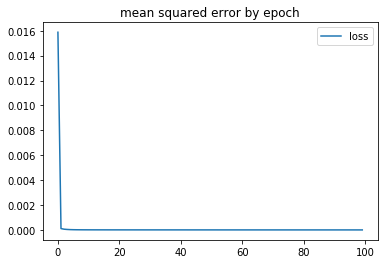

In [26]:
plt.plot(loss.history['loss'], label = 'loss')
plt.title('mean squared error by epoch')
plt.legend()
plt.show()

In [27]:
#Getting the models predicted price values
predictions = model.predict(xtest) 
print(predictions)

[[0.6196842 ]
 [0.6205519 ]
 [0.62058055]
 ...
 [0.5300313 ]
 [0.52891827]
 [0.5291524 ]]


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


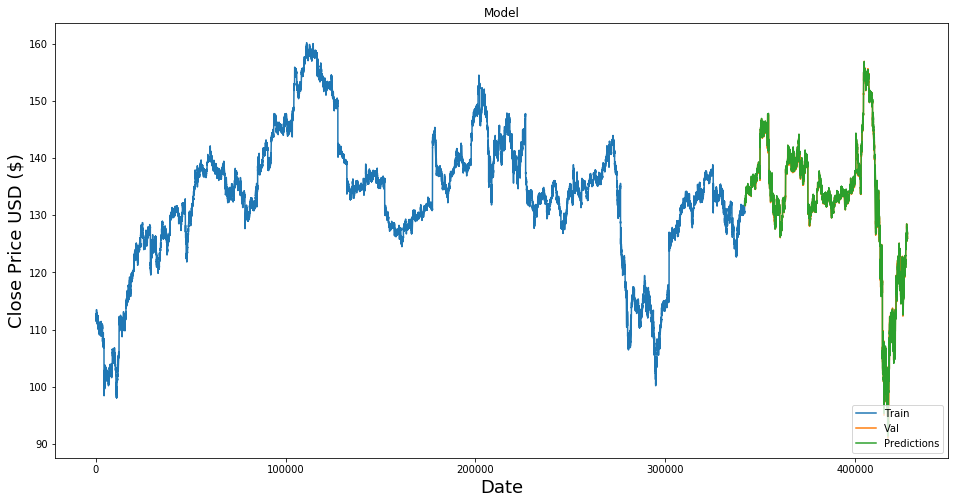

In [28]:
#Undo scaling, show real prediction
# create empty table with 2 fields
trainPredict_dataset_like = np.zeros(shape=(len(predictions), 6) )
# put the predicted values in the right field
trainPredict_dataset_like[:,0] = predictions[:,0]
# inverse transform and then select the right field
predictions = scaler.inverse_transform(trainPredict_dataset_like)[:,0]


train = data.loc[:training_data_len]
valid = data.loc[training_data_len:]
valid['Predictions'] = predictions
#Visualize the data
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

In [29]:
#Show the valid and predicted prices
valid

,Open,High,Low,Volume,Polarity,Close,Predictions
342096,131.780,131.830,131.78,2486,0.267929,131.93,131.845355
342097,131.860,131.880,131.86,3765,0.267929,131.94,131.902630
342098,131.870,131.880,131.87,3616,0.267929,131.96,131.904522
342099,131.870,131.920,131.87,2815,0.267929,131.98,131.936526
342100,131.940,131.960,131.91,4418,0.000000,132.02,131.976248
...,...,...,...,...,...,...,...
427614,126.130,126.270,126.01,24042,0.000000,126.22,126.199620
427615,126.200,126.200,125.90,12299,0.000000,126.41,126.136801
427616,125.910,125.990,125.85,19522,0.000000,126.48,125.927368
427617,125.855,125.910,125.79,24936,0.000000,126.59,125.853895


In [30]:
spark.conf.set("spark.sql.execution.arrow.enabled", "false")
from pyspark.ml.evaluation import RegressionEvaluator

df = valid[['Predictions', 'Close']]
print(df)

df_predictions = spark.createDataFrame(df)
rmse_evaluator = RegressionEvaluator(labelCol="Close", predictionCol="Predictions", metricName="rmse")
rmse = rmse_evaluator.evaluate(df_predictions)

mse_evaluator = RegressionEvaluator(labelCol="Close", predictionCol="Predictions", metricName="mse")
mse = mse_evaluator.evaluate(df_predictions)

mae_evaluator = RegressionEvaluator(labelCol="Close", predictionCol="Predictions", metricName="mae")
mae = mae_evaluator.evaluate(df_predictions)

print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)
print("Mean Square Error (MSE) on test data = %g" % mse)
print("Mean Absolute Error (MAE) on test data = %g" % mae)

        Predictions   Close
342096   131.845355  131.93
342097   131.902630  131.94
342098   131.904522  131.96
342099   131.936526  131.98
342100   131.976248  132.02
...             ...     ...
427614   126.199620  126.22
427615   126.136801  126.41
427616   125.927368  126.48
427617   125.853895  126.59
427618   125.869349  126.25

[85523 rows x 2 columns]
Root Mean Squared Error (RMSE) on test data = 0.35089
Mean Square Error (MSE) on test data = 0.123124
Mean Absolute Error (MAE) on test data = 0.184225
